In [59]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

df = pd.read_csv('full_dataset.csv', encoding="ISO-8859-1")

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#','',text)
    text = text.translate(str.maketrans('','',string.punctuation))
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('indonesian'))
    tokens = [token for token in tokens if token not in stop_words]

    # stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # join tokens to form sentence
    text = ' '.join(tokens)
    return text


# apply the preprocessing to 'Tweet' column
df['Tweet'] = df['Tweet'].apply(preprocess_text)

# save the dataset to CSV file
df.to_csv('clean_full_dataset.csv', index=False, encoding='utf-8')


In [5]:
import pandas as pd
import re

df = pd.read_csv('Pro Khilafah.csv')

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Lowercasing
    text = text.lower()

    # Tokenization (split text into words)
    words = text.split()

    # Join tokens to form the sentence
    preprocessed_text = ' '.join(words)

    return preprocessed_text

# Apply the preprocessing to the 'Tweet' column
df['Tweet'] = df['Tweet'].apply(preprocess_text)

# Save the dataset to a CSV file
df.to_csv('pre_Pro Khilafah2.csv', index=False, encoding='utf-8')


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from operator import itemgetter

# Load your preprocessed data
df = pd.read_csv('pre_Anti-Pancasila.csv')

#handle missing data
df = df.dropna(subset=['Tweet'])

# Tokenize using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Tweet'])

# Create a co-occurrence matrix
co_occurrence_matrix = X.T.dot(X)

# Create a graph
G = nx.Graph()

# Add nodes to the graph
for term in vectorizer.get_feature_names_out():
    G.add_node(term)

# Iterate through your data to add mentions and usernames as nodes
for index, row in df.iterrows():
    tweet = row['Tweet']
    username = row['Username']

    mentions = re.findall(r'@(\w+)', tweet)  # Extract mentions
    G.add_nodes_from(mentions)
    G.add_node(username)

    # Add edges to represent co-occurrence between mentions, usernames, and terms
    for mention in mentions:
        G.add_edge(username, mention, weight=1)

# Rank nodes by degree
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=itemgetter(1), reverse=True)
top_nodes = [node for node, _ in sorted_degrees[:20]]

# Create a filtered subgraph with the top nodes
filtered_graph = G.subgraph(top_nodes)

# export the graph to a gephi-compatible format (GEXF)
nx.write_gexf(G, 'text_network.gexf')


In [33]:
import networkx as nx

# Create a NetworkX graph
G = nx.Graph()

# Iterate through your data and add nodes with usernames as attributes
for index, row in df.iterrows():
    username = row['Username']
    G.add_node(username, username=username)  # Add username as an attribute

# Export the graph to a GEXF file
nx.write_gexf(G, 'text_network_with_usernames.gexf')


Start

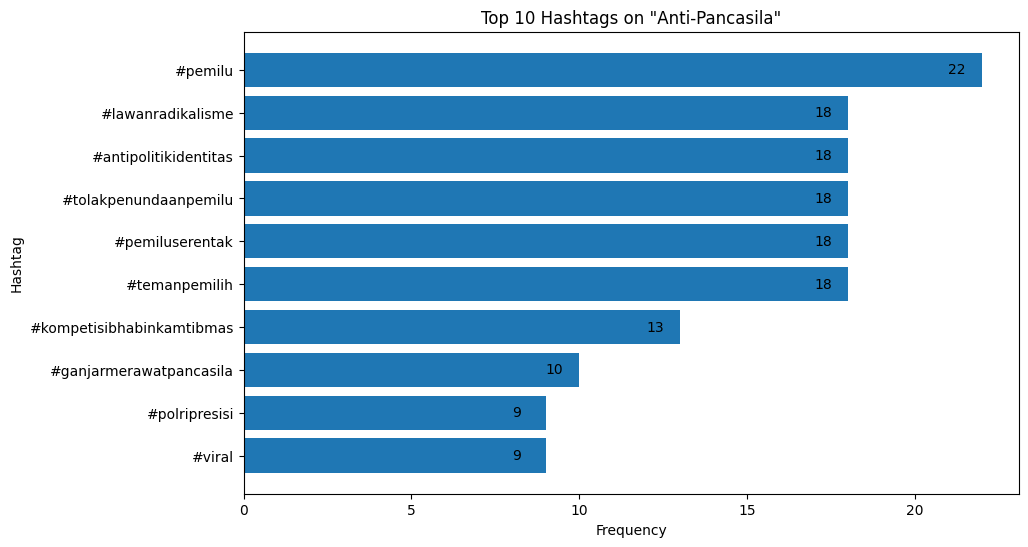

In [37]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load your preprocessed data
df = pd.read_csv('pre_Anti-Pancasila.csv')

# Extract hashtags from the 'Tweet' column
hashtags = []
for tweet in df['Tweet']:
    # Check for non-string values, like NaN
    if not isinstance(tweet, str):
        tweet = str(tweet)

    hashtags.extend(re.findall(r'#\w+', tweet))

# Count the frequency of each hashtag
hashtag_counts = pd.Series(hashtags).value_counts()

# Select the top 10 hashtags
top_10_hashtags = hashtag_counts.head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_hashtags.index, top_10_hashtags.values)
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.title('Top 10 Hashtags on "Anti-Pancasila"')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest count at the top
for bar, count in zip(bars, top_10_hashtags.values):
    plt.text(bar.get_width() - 1, bar.get_y() + bar.get_height() / 2, str(count), ha='left', va='center')
plt.show()


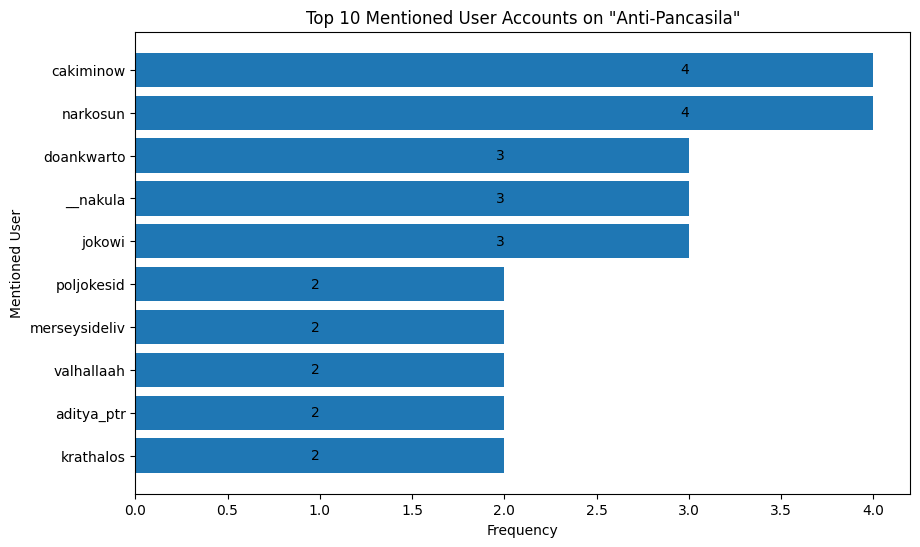

In [10]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load your preprocessed data
df = pd.read_csv('pre_Pro Khilafah2.csv')

# Extract mentions (usernames) from the 'Tweet' column
mentions = []
for tweet in df['Tweet']:
    if isinstance(tweet, str):
        mentions.extend(re.findall(r'@(\w+)', tweet))
    elif pd.notna(tweet):  # Check for NaN values
        mentions.extend(re.findall(r'@(\w+)', str(tweet)))

# Count the frequency of each mention
mention_counts = pd.Series(mentions).value_counts()

# Select the top 10 mentioned user accounts
top_10_mentions = mention_counts.head(10)

# Create a bar chart for top mentions
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_mentions.index, top_10_mentions.values)
plt.xlabel('Frequency')
plt.ylabel('Mentioned User')
plt.title('Top 10 Mentioned User Accounts on "Anti-Pancasila"')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest count at the top

# Annotate the bars with their respective counts inside the bars
for bar, count in zip(bars, top_10_mentions.values):
    plt.text(bar.get_width() - 1, bar.get_y() + bar.get_height() / 2, str(count), ha='right', va='center', color='black')

plt.show()


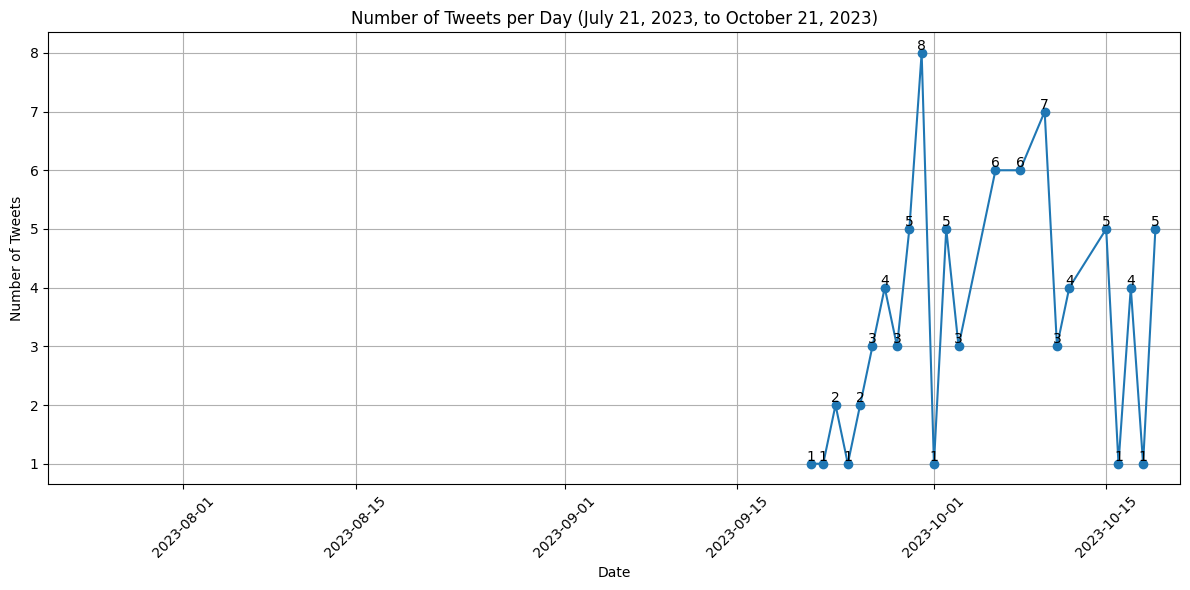

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz  # Import the pytz library

# Load your preprocessed data
df = pd.read_csv('pre_Pro Khilafah2.csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)  # Remove time zone info

# Filter the data to include only dates from July 21, 2023, to October 21, 2023
start_date = datetime(2023, 7, 21)
end_date = datetime(2023, 10, 21)
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Group filtered data by date and count tweets per day
daily_tweet_counts = filtered_df.groupby(filtered_df['Date'].dt.date).size()

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(daily_tweet_counts.index, daily_tweet_counts.values, marker='o', linestyle='-')
plt.title('Number of Tweets per Day (July 21, 2023, to October 21, 2023)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)

# Add data labels (numbers) to the data points
for x, y in zip(daily_tweet_counts.index, daily_tweet_counts.values):
    plt.text(x, y, str(y), ha='center', va='bottom')

# Display the line chart
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.xlim(start_date, end_date)  # Set x-axis limits
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from operator import itemgetter

# Load your preprocessed data
df = pd.read_csv('pre_Anti-Pancasila.csv')

# Handle missing data
df = df.dropna(subset=['Tweet'])

# Tokenize using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Tweet'])

# Create a co-occurrence matrix
co_occurrence_matrix = X.T.dot(X)

# Create a graph
G = nx.Graph()

# Add nodes to the graph (hashtags only)
hashtags = []

# Iterate through your data to add hashtags as nodes
for index, row in df.iterrows():
    tweet = row['Tweet']
    current_hashtags = re.findall(r'#\w+', tweet)
    hashtags.extend(current_hashtags)

    # Add edges to represent co-occurrence between hashtags
    for i in range(len(current_hashtags)):
        for j in range(i + 1, len(current_hashtags)):
            G.add_edge(current_hashtags[i], current_hashtags[j], weight=1)


# Export the graph to a Gephi-compatible format (GEXF)
nx.write_gexf(G, 'Anti-Pancasila Hashtag Network.gexf')


In [40]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from operator import itemgetter
import re

# Load your preprocessed data
df = pd.read_csv('pre_Anti-Pancasila.csv')

# Handle missing data
df = df.dropna(subset=['Tweet'])

# Tokenize using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Tweet'])

# Create a co-occurrence matrix
co_occurrence_matrix = X.T.dot(X)

# Create a graph
G = nx.Graph()

# Add nodes to the graph (mentions only)
mentions = []

# Iterate through your data to add mentions as nodes
for index, row in df.iterrows():
    tweet = row['Tweet']
    current_mentions = re.findall(r'@(\w+)', tweet)
    mentions.extend(current_mentions)

    # Add edges to represent co-occurrence between mentions
    for i in range(len(current_mentions)):
        for j in range(i + 1, len(current_mentions)):
            G.add_edge(current_mentions[i], current_mentions[j], weight=1)

# Export the graph to a Gephi-compatible format (GEXF)
nx.write_gexf(G, 'Anti-Pancasila Mention Network.gexf')


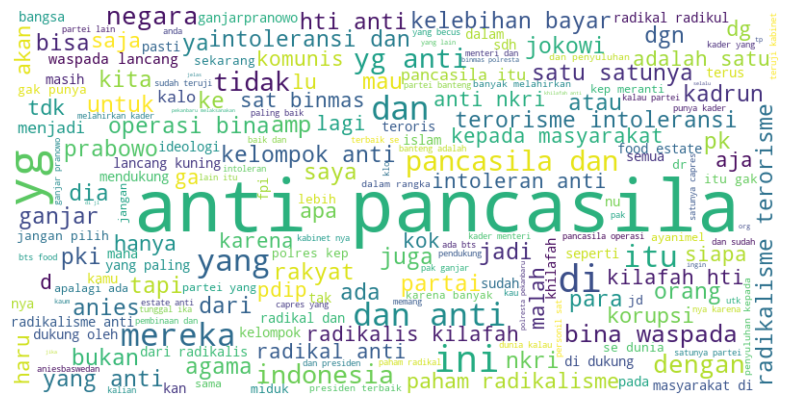

In [46]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv('pre_Anti-Pancasila.csv')
df = df.dropna(subset=['Tweet'])

preprocessed_data = df['Tweet'].tolist()
text = ' '.join(preprocessed_data)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

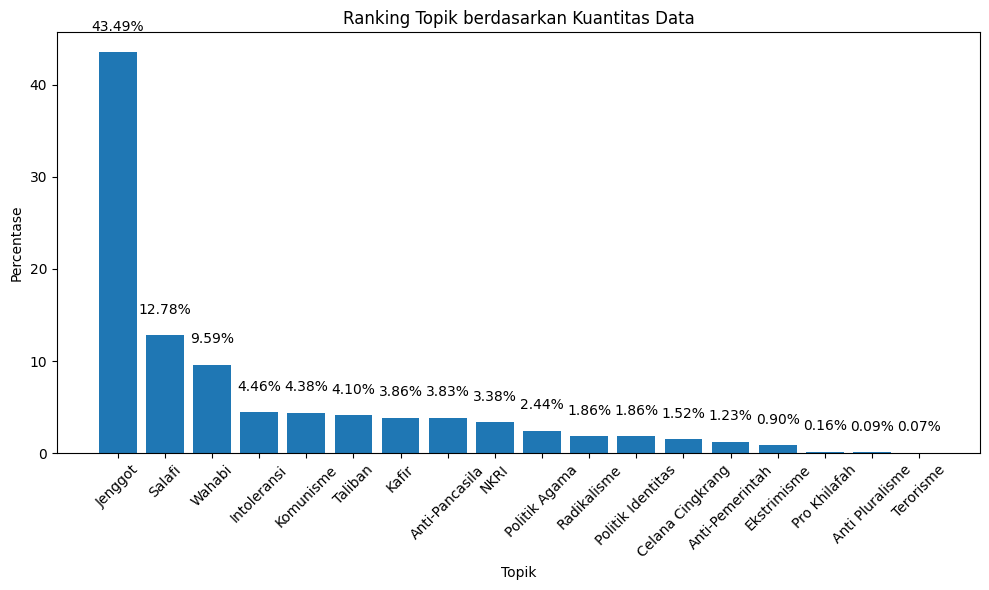

In [7]:
import matplotlib.pyplot as plt

# Your dictionary containing topics and their quantities
tweets = {"Anti-Pancasila": 1979, "Anti-Pemerintah": 635, "Anti Pluralisme": 48, "Celana Cingkrang": 787, "Ekstrimisme":462, "Intoleransi": 2300,"Jenggot": 22447,"Kafir":1990,"Komunisme":2260,"NKRI":1745,"Politik Identitas": 960,"Politik Agama":1260,"Pro Khilafah":82, "Radikalisme":962,"Salafi":6596,"Taliban":2118,"Terorisme":35,"Wahabi":4952}

# Sort the dictionary by quantity in descending order
sorted_tweets = dict(sorted(tweets.items(), key=lambda item: item[1], reverse=True))

# Calculate the total quantity
total_quantity = sum(sorted_tweets.values())

# Calculate percentages
percentages = [(topic, (quantity / total_quantity) * 100) for topic, quantity in sorted_tweets.items()]

# Extract topics and percentages
topics, percentages = zip(*percentages)

# Create a vertical bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(topics, percentages)
plt.xlabel('Topik')
plt.ylabel('Percentase')
plt.title('Ranking Topik berdasarkan Kuantitas Data')

# Label each bar with the percentage
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from operator import itemgetter

# Load your preprocessed data
df = pd.read_csv('pre_Anti-Pancasila.csv')

# Handle missing data
df = df.dropna(subset=['Tweet'])

# Tokenize using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Tweet'])

# Create a co-occurrence matrix
co_occurrence_matrix = X.T.dot(X)

# Create a graph
G = nx.Graph()

# Add nodes to the graph (hashtags only)
hashtags = []

# Iterate through your data to add hashtags as nodes
for index, row in df.iterrows():
    tweet = row['Tweet']
    current_hashtags = re.findall(r'#\w+', tweet)
    hashtags.extend(current_hashtags)

    # Add edges to represent co-occurrence between hashtags
    for i in range(len(current_hashtags)):
        for j in range(i + 1, len(current_hashtags)):
            G.add_edge(current_hashtags[i], current_hashtags[j], weight=1)

# Rank nodes by degree
degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=itemgetter(1), reverse=True)
top_nodes = [node for node, _ in sorted_degrees[:20]]

# Create a filtered subgraph with the top nodes
filtered_graph = G.subgraph(top_nodes)

# Export the graph to a Gephi-compatible format (GEXF)
nx.write_gexf(filtered_graph, 'Anti-Pancasila Hashtag Network.gexf')
